In [47]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
def make_df(folder_path):
    file_list = os.listdir(folder_path)
    
    csv_files = [file for file in file_list]
    
    dfs = []
    
    for file in csv_files:
        file_path = os.path.join(folder_path,file)
        df =pd.read_csv(file_path)
        dfs.append(df)

    combine_df = pd.concat(dfs, ignore_index=True)
    return combine_df

In [3]:
idle_df = make_df('./data/idle')
idle_df['akt'] = 'idle' 
idle_df.shape

(31170, 4)

In [4]:
run_df = make_df('./data/running')
run_df['akt']='running'
run_df.shape

(102240, 4)

In [5]:
stairs_df = make_df('./data/stairs')
stairs_df['akt'] = 'stairs'
stairs_df.shape

(4950, 4)

In [6]:
walk_df = make_df('./data/walking')
walk_df['akt'] = 'walking'
walk_df.shape

(55500, 4)

In [13]:
data=pd.concat([idle_df,run_df,walk_df,stairs_df], ignore_index=True)
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193860 entries, 0 to 193859
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   accelerometer_X  193860 non-null  float64
 1   accelerometer_Y  193860 non-null  float64
 2   accelerometer_Z  193860 non-null  float64
 3   akt              193860 non-null  object 
dtypes: float64(3), object(1)
memory usage: 5.9+ MB


,accelerometer_X,accelerometer_Y,accelerometer_Z
count,193860.000000,193860.000000,193860.000000
mean,1.923550,1.598343,1.804896
std,8.404867,12.474041,7.191590
min,-39.188293,-39.188293,-39.188293
25%,-2.494758,-8.327033,-2.494758
50%,0.248997,-0.009577,0.905008
75%,4.668694,8.671799,7.187394
max,39.188293,39.188293,39.188293


In [31]:
from sklearn.preprocessing import StandardScaler

features = ['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']
scaler=StandardScaler()
data_to_normalize = data[features]
normalized_data = scaler.fit_transform(data_to_normalize)

ndata = data.copy()
ndata[features] = normalized_data
ndata

,accelerometer_X,accelerometer_Y,accelerometer_Z,akt
0,-0.109791,0.241917,0.941538,idle
1,-0.143404,0.209288,0.923560,idle
2,-0.337109,-0.150782,1.028762,idle
3,0.377889,-0.116234,0.919565,idle
4,-0.019205,-0.141185,1.035420,idle
...,...,...,...,...
193855,0.161966,-1.087426,-0.792298,stairs
193856,0.240587,-1.070920,-1.376902,stairs
193857,0.104424,-0.875914,-0.964749,stairs
193858,-0.389523,-0.399146,-0.258964,stairs


Name Axis Domain
Maximum Value x Time
Minimum Value x Time
Entropy x Time
Interquartile Range x Time
Maximum Value y Time
Index of Minimum Value y Time
Mean of absolute deviation y Time
Median y Time
Skewness y Time
Standard deviation y Time
Root mean square error y Time
Skewness z Time
Normalized value of FFT coefficients x Frequency
Normalized value of FFT coefficients y Frequency
Normalized value of FFT coefficients z Frequenc

In [33]:
def iqr(data):
    sorted_data = np.sort(data)
    Q1 = np.percentile(sorted_data, 25)
    Q3 = np.percentile(sorted_data, 75)
    IQR = Q3 - Q1
    return IQR

def argmin(data):
   return np.argmin(data)

def entropy(column_data):
    hist, bins = np.histogram(column_data, bins='auto')
    probs = hist / len(column_data)
    probs = probs[probs > 0]
    entropy = -np.sum(probs * np.log2(probs))
    return entropy

def mad(data):
    mean = np.mean(data)
    absolute_deviations = np.abs(data - mean)
    mad = np.mean(absolute_deviations)
    return mad

def rmse(data):
    mean = np.mean(data)
    squared_errors = [(x - mean) ** 2 for x in data]
    rmse = np.sqrt(np.mean(squared_errors))
    return rmse

In [37]:
axis_aggregations = {
    'accelerometer_X': ["max", "min", entropy, iqr],
    'accelerometer_Y': ["max", argmin, mad, "median", "skew", "std", rmse],
    'accelerometer_Z': ["skew"]
}

data_tdf = pd.DataFrame()


for axis, functions in axis_aggregations.items():
    axis_data = ndata.groupby(["akt", ndata.index // 30])[axis].agg(functions)

    multiindex = pd.MultiIndex.from_product([[axis], axis_data.columns])

    axis_data.columns = multiindex
    data_tdf = pd.concat([data_tdf, axis_data], axis=1)

data_tdf.reset_index(level=0, inplace=True)

In [39]:
data_tdf

akt accelerometer_X                               accelerometer_Y  \
                          max       min   entropy       iqr             max   
0        idle        0.377889 -0.337109  3.075701  0.007834        0.241917   
1        idle       -0.180436 -0.267033  2.732915  0.004700       -0.126214   
2        idle       -0.236268 -0.243675  2.389898  0.002564       -0.108556   
3        idle       -0.162205 -0.196958  2.663458  0.005982       -0.121224   
4        idle       -0.162205 -0.196958  2.384778  0.006125       -0.121224   
...       ...             ...       ...       ...       ...             ...   
6292  walking        0.626857 -0.941581  2.507218  0.666429       -0.113547   
6293  walking        0.626857 -1.104521  2.421421  0.599060       -0.113547   
6294  walking        1.093457 -1.104521  2.295601  0.595784       -0.113547   
6295  walking        1.093457 -1.104521  2.441946  0.525424       -0.113547   
6296  walking        1.093457 -1.104521  2.380542  0.770973       -0.113547   

                                                              accelerometer_Z  
     argmin       mad    median      skew       std      rmse            skew  
0         2  0.045375 -0.138690  3.647470  0.092801  0.091241       -2.365312  
1         7  0.002278 -0.138690  0.568223  0.003853  0.003788       -2.409922  
2        14  0.000966 -0.110092 -1.272920  0.001313  0.001291       -0.097477  
3        28  0.003037 -0.129861 -0.857829  0.004371  0.004298        0.565957  
4        26  0.002952 -0.129669 -1.001079  0.004329  0.004257        0.453139  
...     ...       ...       ...       ...       ...       ...             ...  
6292     18  0.328695 -0.963052 -0.540493  0.423706  0.416584        1.221757  
6293     16  0.334778 -0.963052 -0.523121  0.427288  0.420106        1.178148  
6294     14  0.346932 -0.963052 -0.453662  0.433905  0.426612        1.996085  
6295     12  0.331504 -0.989731 -0.365569  0.424419  0.417285        1.959435  
6296     10  0.339666 -0.963052 -0.354875  0.436354  0.429020        1.950320  

[6462 rows x 13 columns]

In [43]:
from sklearn.model_selection import train_test_split

In [45]:
X_train,X_test, y_train,y_test = train_test_split(data_tdf[features], data_tdf['akt'], test_size=0.3,
    stratify=data_tdf["akt"])

In [53]:
%%time
model_svm = SVC()
model_svm.fit(X_train, y_train)

CPU times: total: 188 ms
Wall time: 187 ms


SVC()

In [57]:
%%time
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

CPU times: total: 578 ms
Wall time: 591 ms


RandomForestClassifier()

In [69]:
score_svm = model_svm.score(X_test, y_test)
score_rf = model_rf.score(X_test, y_test)
print(score_svm, score_rf)

0.9731820526044352 0.998452810727179


In [71]:
y_svm=model_svm.predict(X_test)
y_rf=model_rf.predict(X_test)

In [75]:
conf_matrix_svm = confusion_matrix(y_svm, y_test)
conf_matrix_rf = confusion_matrix(y_rf, y_test)

In [81]:
data_tdf['akt'].unique()

array(['idle', 'running', 'stairs', 'walking'], dtype=object)

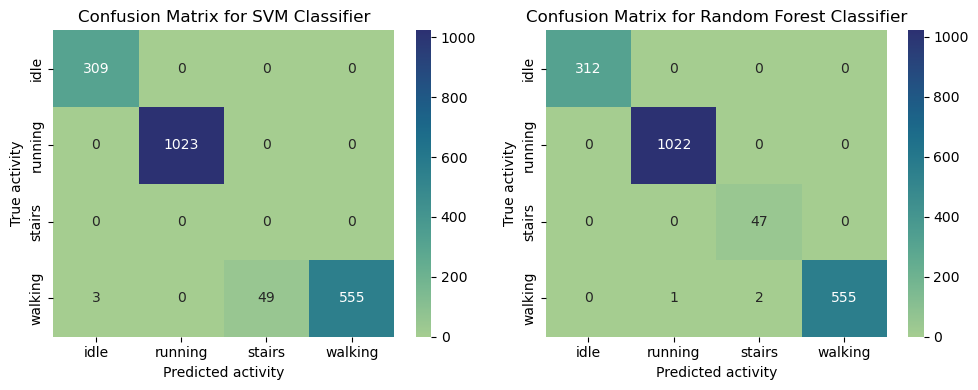

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

classifiers = ["SVM", "Random Forest"]
confusion_matrices = [conf_matrix_svm, conf_matrix_rf]

for i, classifier in enumerate(classifiers):
    sns.heatmap(
        confusion_matrices[i],
        annot=True,
        fmt='d',
        cmap='crest',
        xticklabels=data_tdf['akt'].unique(),
        yticklabels=data_tdf['akt'].unique(),
        ax=axes[i],
    )
    axes[i].set_title(f"Confusion Matrix for {classifier} Classifier")
    axes[i].set_xlabel("Predicted activity")
    axes[i].set_ylabel("True activity")

plt.tight_layout()

plt.show()